In [ ]:
pip install shap lime

***Loading the Dataset***

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1) (2).zip


In [ ]:
import zipfile

with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

import os
os.listdir('/content/')


['.config',
 'archive (1) (1).zip',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'archive (1) (2).zip',
 'archive (1).zip',
 'sample_data']

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


***Explore and preprocess customer data to handle missing values and outliers***

In [ ]:
# Handling missing values
data.fillna(method='ffill', inplace=True)

# Encoding categorical variables
data = pd.get_dummies(data, drop_first=True)

# Spliting the data into features and target variable
X = data.drop('Churn_Yes', axis=1)  
y = data['Churn_Yes']

<ipython-input-5-f6eb810d389a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Missing values after imputation:
SeniorCitizen            0
tenure                   0
MonthlyCharges           0
customerID_0003-MKNFE    0
customerID_0004-TLHLJ    0
                        ..
TotalCharges_998.1       0
TotalCharges_999.45      0
TotalCharges_999.8       0
TotalCharges_999.9       0
Churn_Yes                0
Length: 13602, dtype: int64



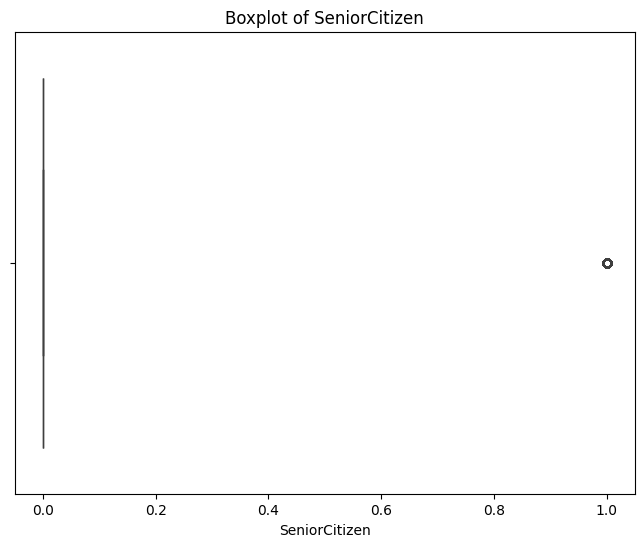

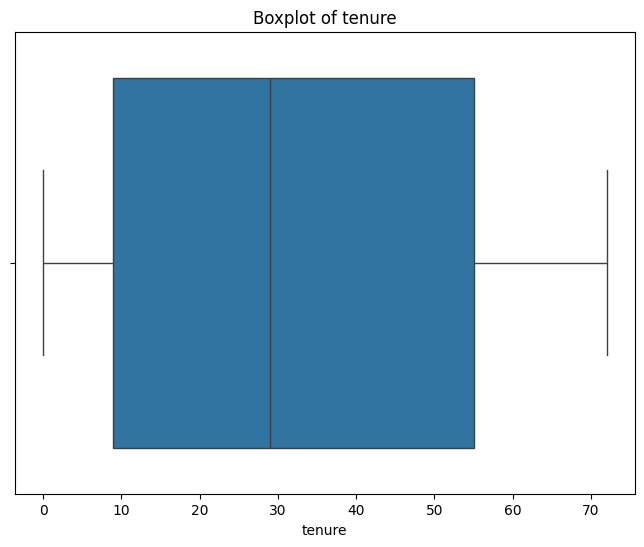

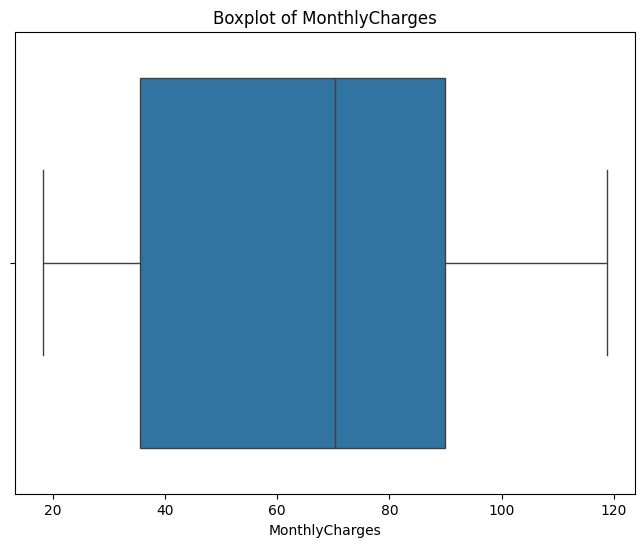

Outliers detected in each column:
SeniorCitizen     1142
tenure               0
MonthlyCharges       0
dtype: int64

Dataset shape before removing outliers: (7043, 13602)
Dataset shape after removing outliers: (5901, 13602)


In [ ]:
# Imputing missing values with the mode for categorical columns
for column in data.select_dtypes(include=['object']).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Checking after filling missing values
missing_data_after = data.isnull().sum()
print(f"Missing values after imputation:\n{missing_data_after}\n")

# Visualizing the distribution of numerical data
numerical_cols = data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Identifying outliers (IQR - Interquartile Range)
Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Defining the outlier boundaries
outlier_lower = Q1 - 1.5 * IQR
outlier_upper = Q3 + 1.5 * IQR

# Checking which data points are considered outliers
outliers = ((data[numerical_cols] < outlier_lower) | (data[numerical_cols] > outlier_upper)).sum()

# Displaying outliers summary
print(f"Outliers detected in each column:\n{outliers}\n")

# Handling outliers (Removing rows with outliers)
data_cleaned = data[~((data[numerical_cols] < outlier_lower) | (data[numerical_cols] > outlier_upper)).any(axis=1)]

print(f"Dataset shape before removing outliers: {data.shape}")
print(f"Dataset shape after removing outliers: {data_cleaned.shape}")


In [ ]:
# Converting boolean columns to integers
X = X.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# One-hot encoding categorical features if necessary
X_encoded = pd.get_dummies(X, drop_first=True)


***Training the Model***

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

 **SHAP (SHapley Additive exPlanations)** to explain model predictions and to interpret model results to identify key factors influencing churn

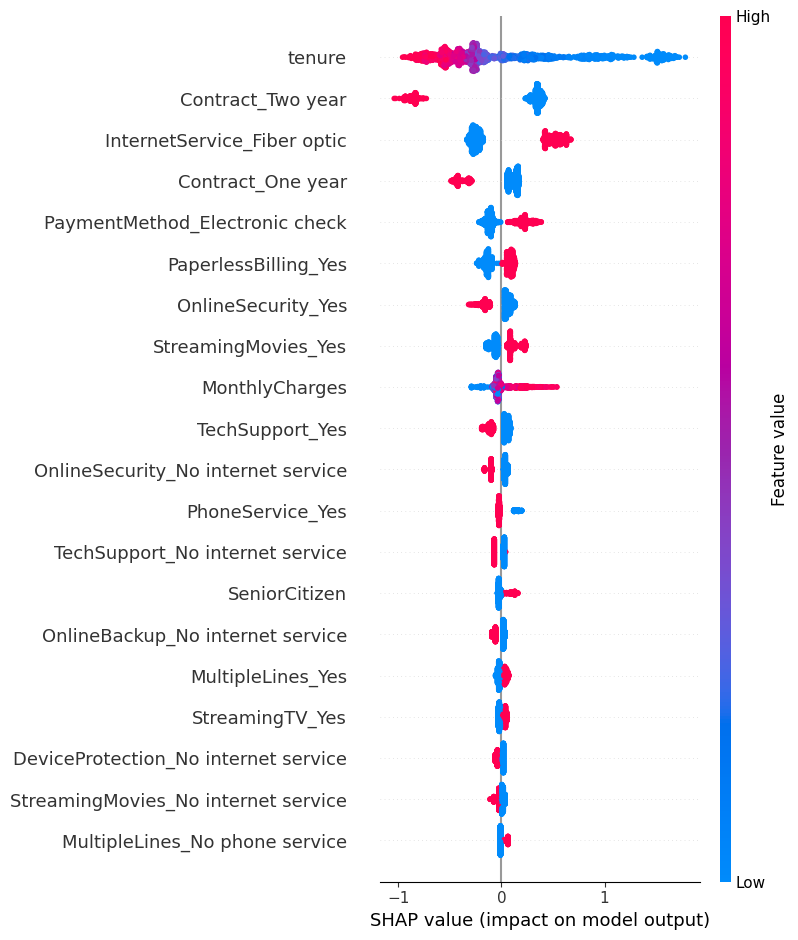


Top Factors Influencing Churn (SHAP):
InternetService_Fiber optic: 0.0881
tenure: 0.0463
Contract_Two year: 0.0432
Contract_One year: 0.0251
MonthlyCharges: 0.0104


In [ ]:
import shap

# Creating a SHAP explainer object with the trained model
explainer = shap.Explainer(model, X_train)

# Generating SHAP values for the test set
shap_values = explainer(X_test)

# Visualizing the SHAP summary plot to interpret the model's predictions
shap.summary_plot(shap_values, X_test)

# The mean absolute SHAP values for each feature
shap_feature_importance = shap_values.values.mean(axis=0)
shap_feature_names = X_train.columns

# Sorting the features based on their mean absolute SHAP values in descending order
shap_sorted_idx = shap_feature_importance.argsort()[::-1]

# The top 5 features that influence churn based on SHAP
print("\nTop Factors Influencing Churn (SHAP):")
for i in range(5):
    feature = shap_feature_names[shap_sorted_idx[i]]
    importance = shap_feature_importance[shap_sorted_idx[i]]
    print(f"{feature}: {importance:.4f}")


**LIME (Local Interpretable Model-agnostic Explanations)** to explain model predictions and to interpret model results to identify key factors influencing churn

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



Top Factors Influencing Churn (LIME):
customerID_8945-MUQUF <= 0.00: -0.2572
customerID_3768-NLUBH <= 0.00: -0.2029
customerID_2484-DGXPZ <= 0.00: -0.1766
TotalCharges_812.4 <= 0.00: -0.1485
customerID_1094-BKOSX <= 0.00: -0.1411


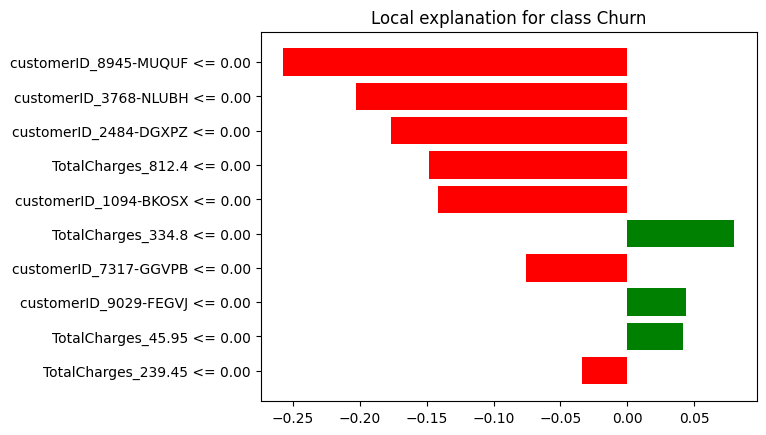

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Initializing the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Use training data
    feature_names=X_train.columns,  # Feature names
    class_names=["No Churn", "Churn"],  # Target labels
    mode="classification"  
)

# Choosing the first instance from the test set to explain
instance = X_test.iloc[0].values.reshape(1, -1)

# Generating the explanation for the chosen instance
explanation = explainer.explain_instance(instance[0], model.predict_proba)

# Visualising the explanation as a bar chart
explanation.as_pyplot_figure()

# The top 5 features based on LIME explanation
top_features = explanation.as_list()[:5]

# Printing the top 5 features that influence churn based on LIME
print("\nTop Factors Influencing Churn (LIME):")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


***Testing the model with a sample data***

Prediction for customer (Modified): Churn


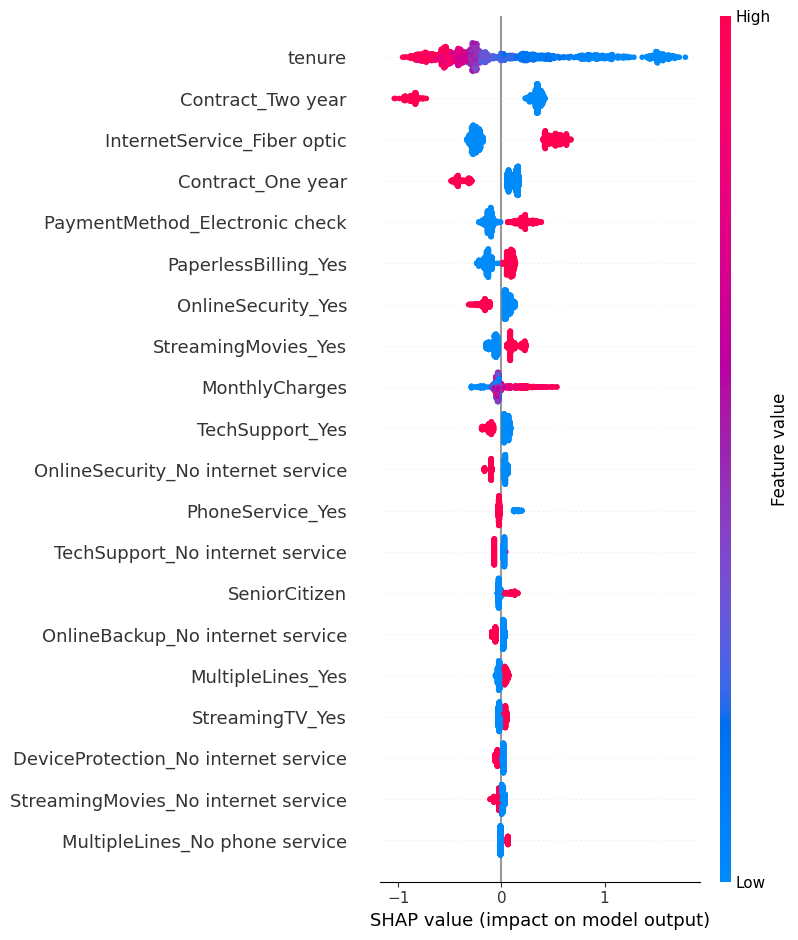


Top Factors Influencing Churn (SHAP):
InternetService_Fiber optic: 0.0881
tenure: 0.0463
Contract_Two year: 0.0432
Contract_One year: 0.0251
MonthlyCharges: 0.0104


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



Top Factors Influencing Churn (LIME):
customerID_7951-QKZPL <= 0.00: -0.3022
customerID_7845-URHJN <= 0.00: -0.2417
customerID_1430-SFQSA <= 0.00: -0.2384
customerID_4464-JCOLN <= 0.00: -0.1786
TotalCharges_6991.9 <= 0.00: -0.1117


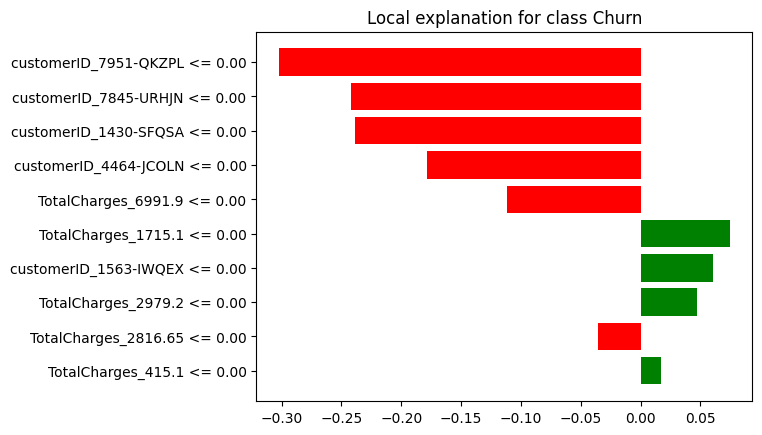

In [ ]:
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd

# Sample of customer data
sample_customer = {
    'SeniorCitizen': 0,
    'tenure': 5,
    'MonthlyCharges': 60.5,
    'TotalCharges': 305.5,
    'gender_Male': 1,
    'Partner_Yes': 0,
    'Dependents_Yes': 1,
    'PhoneService_Yes': 1,
    'MultipleLines_Yes': 0,
    'InternetService_Fiber optic': 1,
    'OnlineSecurity_Yes': 1,
    'OnlineBackup_Yes': 0,
    'DeviceProtection_Yes': 1,
    'TechSupport_Yes': 0,
    'StreamingTV_Yes': 1,
    'StreamingMovies_Yes': 0,
    'Contract_Two year': 0,
    'PaperlessBilling_Yes': 1,
    'PaymentMethod_Bank transfer (automatic)': 0
}


sample_customer_df = pd.DataFrame([sample_customer])

sample_customer_encoded = pd.get_dummies(sample_customer_df, drop_first=True)

sample_customer_encoded = sample_customer_encoded.reindex(columns=X_train.columns, fill_value=0)

prediction = model.predict(sample_customer_encoded)

print(f"Prediction for customer (Modified): {'Churn' if prediction == 1 else 'No Churn'}")

explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

shap_feature_importance = shap_values.values.mean(axis=0)
shap_feature_names = X_train.columns

shap_sorted_idx = shap_feature_importance.argsort()[::-1]

print("\nTop Factors Influencing Churn (SHAP):")
for i in range(5):
    feature = shap_feature_names[shap_sorted_idx[i]]
    importance = shap_feature_importance[shap_sorted_idx[i]]
    print(f"{feature}: {importance:.4f}")

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=["No Churn", "Churn"],
    mode="classification"
)

lime_explanation = lime_explainer.explain_instance(sample_customer_encoded.values[0], model.predict_proba)

lime_explanation.as_pyplot_figure()

lime_sorted_features = sorted(lime_explanation.as_list(), key=lambda x: abs(x[1]), reverse=True)

print("\nTop Factors Influencing Churn (LIME):")
for i in range(5):
    feature, importance = lime_sorted_features[i]
    print(f"{feature}: {importance:.4f}")
